Loading and preprocessing data...
Performing causal discovery using FCI algorithm...


  0%|          | 0/52 [00:00<?, ?it/s]

X3 --> X41
X8 --> X6
X20 --> X6
X7 --> X13
X8 --> X45
X35 --> X10
X39 --> X10
X11 --> X35
X16 --> X52
X18 --> X19
X29 --> X23
X23 --> X31
X30 --> X24
X24 --> X32
X42 --> X26
X27 --> X33
X38 --> X33
X47 --> X35
X45 --> X42
X42 --> X52


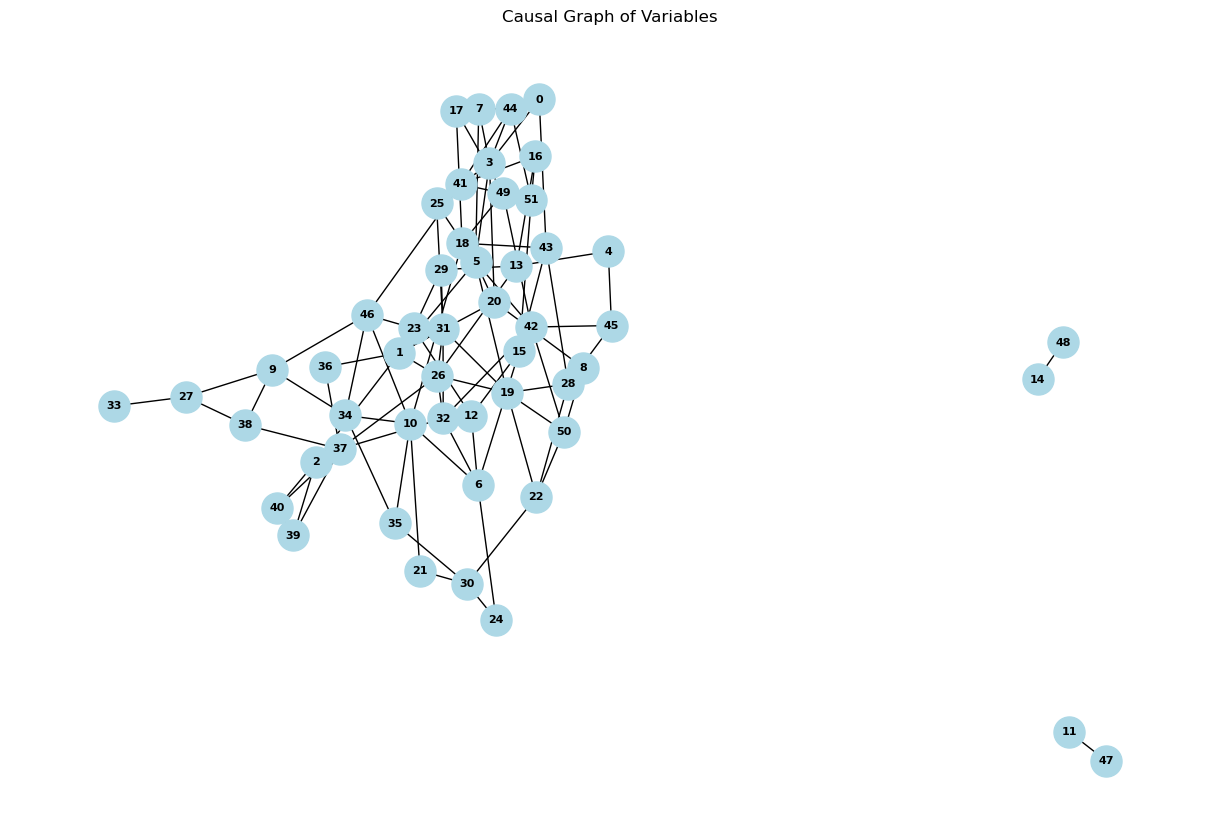

Epoch 1/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 2/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 3/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 4/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 5/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 6/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 7/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 8/200: Train F1: 0.9180, Test F1: 0.9170
Epoch 9/200: Train F1: 0.9180, Test F1: 0.9169
Epoch 10/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 11/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 12/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 13/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 14/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 15/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 16/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 17/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 18/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 19/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 20/200: Train F1: 0.9179, Test F1: 0.9170
Epoch 21/200: Train F1: 0.9179, Test F1: 0.9170
E

/tmp/ipykernel_53281/3295044229.py:244: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


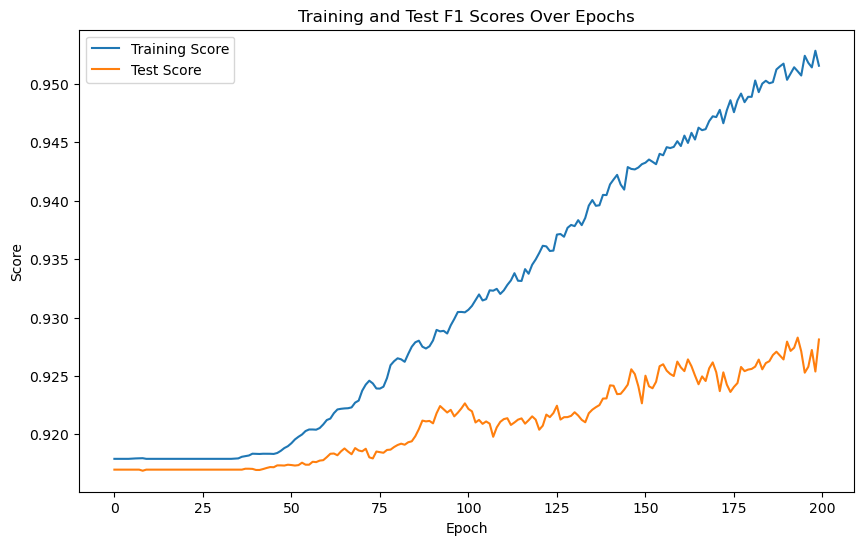

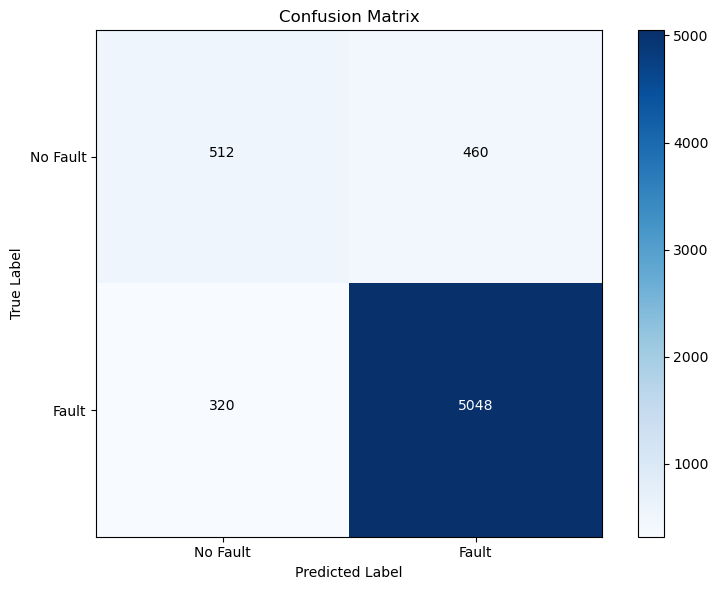

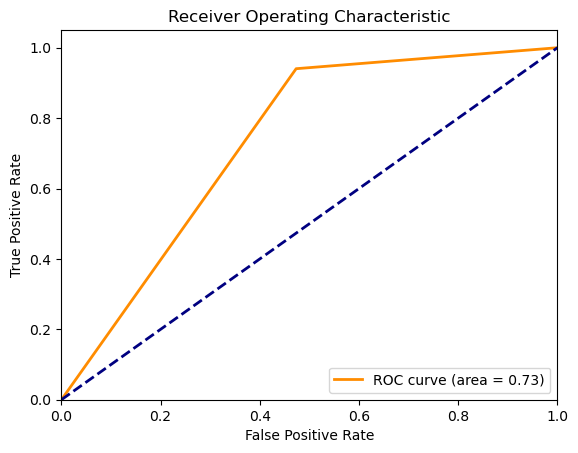

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_auc_score, 
                             matthews_corrcoef, log_loss, roc_curve, auc)
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.graph.GeneralGraph import GeneralGraph
import networkx as nx

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the path to the dataset
data_path = 'Documents/tennessee-eastmen-process-classification/TE_process/data/'

def load_data(file_path):
    data = pd.read_csv(file_path, sep=r'\s+', header=None)
    return data.values

def create_dataset():
    X = []
    y = []
    
    for i in range(22):
        train_file = os.path.join(data_path, f'd{i:02d}.dat')
        train_data = load_data(train_file)
        X.append(train_data)
        y.append(np.full(train_data.shape[0], 1 if i > 0 else 0))
        
        test_file = os.path.join(data_path, f'd{i:02d}_te.dat')
        test_data = load_data(test_file)
        X.append(test_data)
        if i == 0:
            y.append(np.zeros(test_data.shape[0]))
        else:
            y.append(np.concatenate([np.zeros(160), np.ones(test_data.shape[0] - 160)]))
    
    X = np.vstack(X)
    y = np.concatenate(y)
    
    return X, y

def plot_causal_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
    plt.title("Causal Graph of Variables")
    plt.show()

def general_graph_to_networkx(g: GeneralGraph) -> nx.Graph:
    G = nx.Graph()
    n_nodes = g.get_nodes().__len__()
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            if g.graph[i, j] != 0:  # If there's an edge
                G.add_edge(i, j)
    return G

def create_edge_index(G, num_nodes):
    edge_index = []
    for edge in G.edges():
        edge_index.append([edge[0], edge[1]])
        edge_index.append([edge[1], edge[0]])  # Add reverse edge for undirected graph
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

class CausalGNN(nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(CausalGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels // 2)
        self.fc = nn.Linear(hidden_channels // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.fc(x)
        return torch.sigmoid(x)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index).squeeze()
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    out_probs = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index).squeeze()
            pred = (out > 0.5).float()
            predictions.extend(pred.cpu().numpy())
            out_probs.extend(out.cpu().numpy())
            targets.extend(data.y.cpu().numpy())
    return (accuracy_score(targets, predictions), precision_score(targets, predictions), 
            recall_score(targets, predictions), f1_score(targets, predictions),
            matthews_corrcoef(targets, predictions), roc_auc_score(targets, out_probs),
            log_loss(targets, out_probs), predictions, targets)

def plot_training_history(train_scores, test_scores, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_scores, label='Training Score')
    plt.plot(test_scores, label='Test Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks([0, 1], ['No Fault', 'Fault'])
    plt.yticks([0, 1], ['No Fault', 'Fault'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def main():
    print("Loading and preprocessing data...")
    X, y = create_dataset()
    
    print("Performing causal discovery using FCI algorithm...")
    fci_result = fci(X)
    general_graph = fci_result[0]
    G = general_graph_to_networkx(general_graph)
    plot_causal_graph(G)
    
    edge_index = create_edge_index(G, X.shape[1])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    train_data = Data(x=torch.tensor(X_train, dtype=torch.float32),
                      edge_index=edge_index,
                      y=torch.tensor(y_train, dtype=torch.float32))
    test_data = Data(x=torch.tensor(X_test, dtype=torch.float32),
                     edge_index=edge_index,
                     y=torch.tensor(y_test, dtype=torch.float32))
    
    train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
    test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CausalGNN(num_features=X.shape[1], hidden_channels=128).to(device)
    
    criterion = FocalLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
    
    num_epochs = 200
    patience = 70
    best_f1 = 0
    counter = 0
    train_f1_scores = []
    test_f1_scores = []
    
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        train_acc, train_prec, train_rec, train_f1, train_mcc, train_auc, train_logloss, _, _ = evaluate_model(model, train_loader, device)
        test_acc, test_prec, test_rec, test_f1, test_mcc, test_auc, test_logloss, test_preds, test_targets = evaluate_model(model, test_loader, device)
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}')
        
        train_f1_scores.append(train_f1)
        test_f1_scores.append(test_f1)
        
        # Early stopping
        if test_f1 > best_f1:
            best_f1 = test_f1
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Final evaluation
    test_acc, test_prec, test_rec, test_f1, test_mcc, test_auc, test_logloss, test_preds, test_targets = evaluate_model(model, test_loader, device)
    print(f"Final Test Results: Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}, AUC: {test_auc:.4f}, Log Loss: {test_logloss:.4f}")
    
    plot_training_history(train_f1_scores, test_f1_scores, "Training and Test F1 Scores Over Epochs")
    plot_confusion_matrix(test_targets, test_preds)
    plot_roc_curve(test_targets, test_preds)

if __name__ == '__main__':
    main()
